# Bike Share Analysis and Daily Users Predictor

## Introduction

Bike sharing in Seoul, Korea was founded in 2015 and has grown to become the city’s most popular form of public transportation, gaining over 100 million users in 6 and a half years. It became popular as many citizens favored traveling shorter distances by bike rather than taking crowded transit. Amidst the pandemic, users skyrocketed as many people found it a useful means of transportation to avoid crowded public transit (Joo-Heon, 2022). While this played a factor in an increase in users, there are still other factors that come into play that determine whether citizens are willing to use bikes as a mode of transportation. The question we will be trying to answer with our project is: In 2018, in Seoul, Korea, what were the strongest environmental predictors of the quantity of bikes rented out each day, and how effectively can those predictors be used to predict the number of bikes rented out in a given day given the environmental conditions of that day?  Our dataset contains information on the weather and environmental factors of each hour of each day during 2018. The observations in the data set report on temperature, humidity, windspeed, visibility, dewpoint, solar radiation, snowfall, and rainfall. The dataset also includes observations relating to whether the bike rental facility was functional during that particular day, as well as whether the given day was a holiday.

## Methods & Results

Below, we load the libraries and demonstrate that the data can be read in R.

In [1]:
library(tidyverse)
library(tidymodels)
library(GGally)
library(kknn)
options(repr.matrix.max.rows = 10)

── Attaching packages ──────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ─────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ─────────────────────────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ────────────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard(

#### Table 1: Original Bike Data

In [2]:
bike_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv", locale=locale(encoding="latin1"))
bike_data

Rows: 8760 Columns: 14
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Date, Seasons, Holiday, Functioning Day
dbl (10): Rented Bike Count, Hour, Temperature(°C), Humidity(%), Wind speed ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,Yes
01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,Yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0,0,0,Autumn,No Holiday,Yes
30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0,0,0,Autumn,No Holiday,Yes
30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0,0,0,Autumn,No Holiday,Yes


In Table 1, we present the original bike data from the internet which includes all of the variables and their units.

Next, we wrangle our data into tidy format, and use `group_by()` and `summarize()` to group the number of rented bikes by day. This produces a table of our clean data which includes the 8 different environmental factors that we wish to explore.

#### Table 2: Clean Bike Data

In [3]:
colnames(bike_data) <- c("date", "bike_count", "hour", "temperature", "humidity", "wind_speed", "visibility", "dew_point_temp", "solar_radiation", "rainfall", "snowfall", "seasons", "holiday", "functioning_day") 

bike_data_clean <- bike_data |>
    filter(functioning_day == "Yes") |>
    group_by(date) |>
    summarize(bike_count = sum(bike_count), 
              temperature = mean(temperature),
              humidity = mean(humidity),
              wind_speed = mean(wind_speed),
              visibility = mean(visibility),
              dew_point_temp = mean(dew_point_temp),
              solar_radiation = mean(solar_radiation),
              rainfall = mean(rainfall),
              snowfall = mean(snowfall)) |>
    select(-date)
bike_data_clean

bike_count,temperature,humidity,wind_speed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4290,-1.283333,39.33333,1.454167,1894.8333,-13.866667,0.2558333,0.0000000,0.0000000
5377,-3.866667,44.00000,1.608333,1923.6250,-15.012500,0.3370833,0.0000000,0.9041667
5132,0.450000,64.20833,3.554167,1084.0000,-6.387500,0.7475000,0.1041667,0.0000000
17388,15.183333,68.91667,1.570833,831.8333,9.370833,0.3020833,0.0000000,0.0000000
26820,20.341667,72.79167,1.437500,456.4583,15.120833,0.5175000,0.0000000,0.0000000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
31681,20.525000,61.20833,1.941667,1246.208,11.491667,1.1225000,0.000000000,0.0000000
22897,32.525000,49.62500,1.383333,1993.792,20.216667,1.0208333,0.000000000,0.0000000
27817,25.558333,67.16667,1.600000,1609.000,18.491667,0.9237500,0.004166667,0.0000000


In Table 2, we present the data in tidy format. The data has been wrangled to group by day instead of by hour.

To further explore our data, we will create a histogram that shows the distribution of rented bikes per day.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


mean,med,sd
<dbl>,<dbl>,<dbl>
17485.31,18563,9937.165


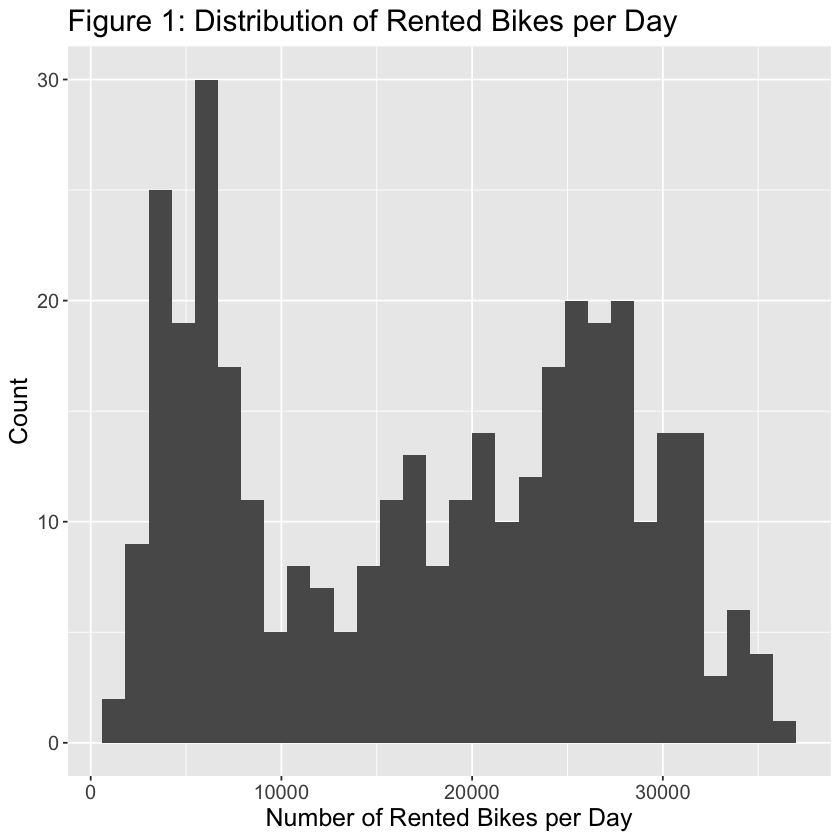

In [4]:
bike_hist <- ggplot(bike_data_clean, aes(x = bike_count)) +
    geom_histogram() +
    labs(x = "Number of Rented Bikes per Day", y = "Count") +
    ggtitle("Figure 1: Distribution of Rented Bikes per Day") +
    theme(text = element_text(size = 15))
bike_hist

bike_param <- bike_data_clean %>%
    summarize(mean = mean(bike_count),
              med = median(bike_count),
              sd = sd(bike_count))
bike_param

In Figure 1, the distribution shows that the number of rented bikes per day takes on a bimodal shape with two peaks. The distribution ranges from just above 0 to over 35,000 bikes rented, with an average of 17,485 bikes rented per day.  

Next, we split our data into training and testing sets so that we can train our models with the training data (70%), and test our models with the testing data (30%):

In [5]:
set.seed(2020)
bike_split <- initial_split(bike_data_clean, prop = 0.7, strata = bike_count)
bike_training <- training(bike_split)
bike_testing <- testing(bike_split)

Then, to assess the correlation between the amount of bikes rented and the environmental/weather predictors, we use `ggpairs` to give a rough visual idea of which environmental/weather factors have the strongest correlation in regards to the amount of bikes rented per day. 

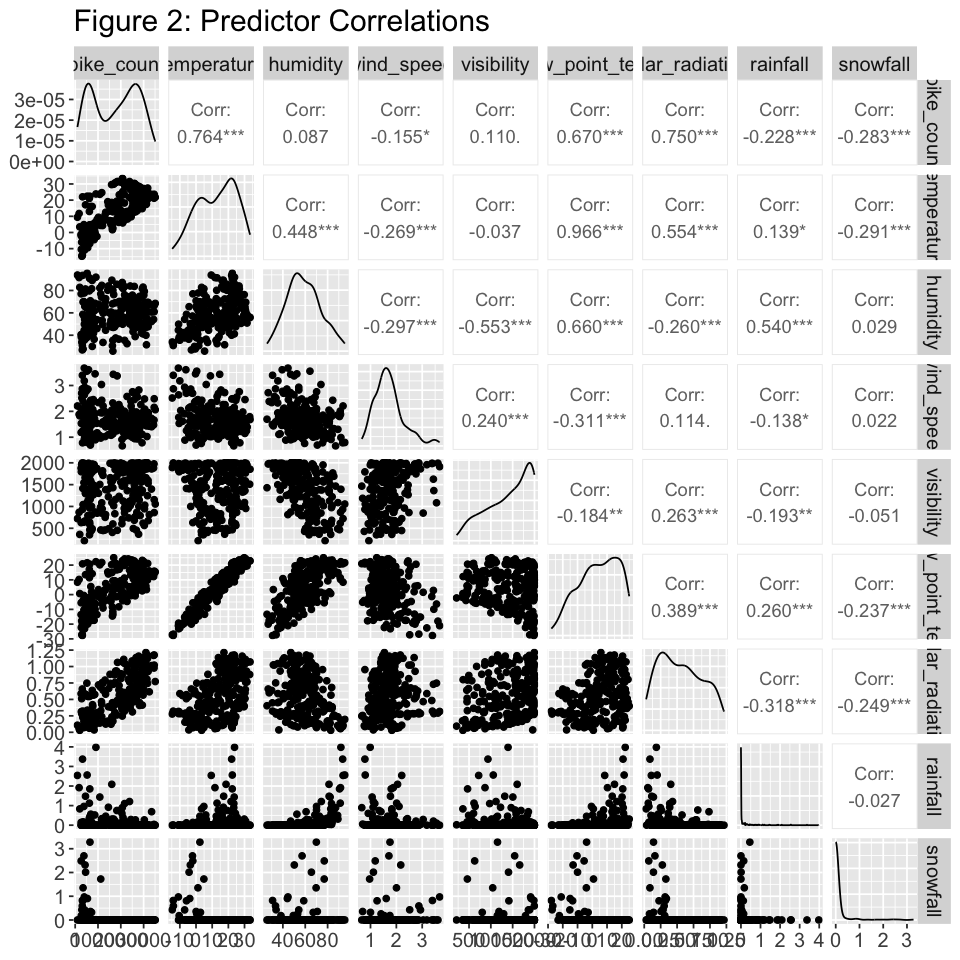

In [6]:
options(repr.plot.width = 8, repr.plot.height = 8)
bike_pairs <- bike_training |>
    ggpairs() +
    ggtitle("Figure 2: Predictor Correlations") +
    theme(text = element_text(size = 15))
bike_pairs

Figure 2 shows the scatter plots of all variables plotted against each other, and shows the different correlation coefficients between all variables.

Next, we will use the `cor` function with the `as_tibble` function to create a table containing the correlations of all the environmental factors with the bike count of a given day. We take the absolute value of all these correlation coefficients because we are only concerned with the strength (magnitude) of the correlations instead of the direction.

Using the table above containing the correlation coefficients of all the factors in relation to bike count, we plot the bar graph below. This allows us to easily visualize which environmental factors correlate best with bikes rented per day.

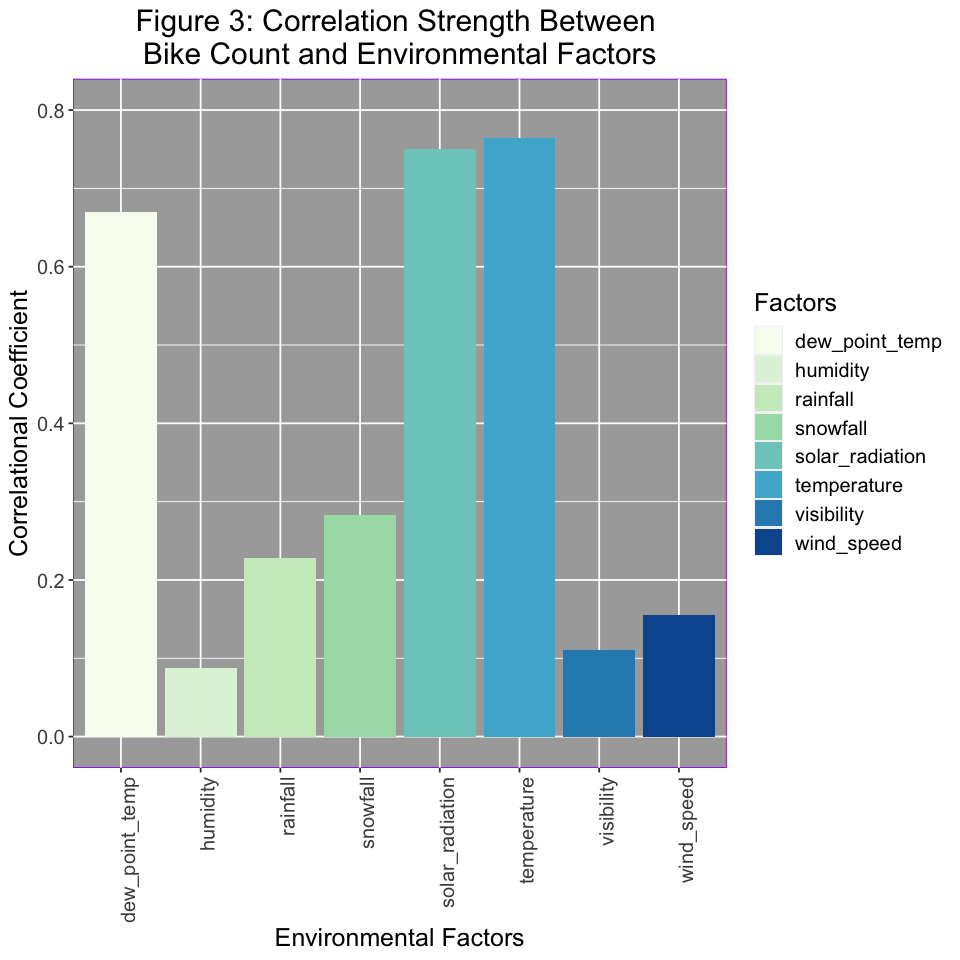

In [7]:
bike_cors <- cor(bike_training)[1,] |>
    as_tibble()
colnames(bike_cors) <- c("r")
bike_cors$factors <- names(bike_data_clean)
bike_cors <- filter(bike_cors, factors != "bike_count") |>
    mutate(r = abs(r))
bike_cors_plot <- bike_cors |>
    ggplot(aes(x = factors, y = r, fill = factors)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(x = "Environmental Factors", 
            y = "Correlational Coefficient",
            fill = "Factors") +
        ggtitle("Figure 3: Correlation Strength Between \nBike Count and Environmental Factors") +
        scale_y_continuous(limits = c(0,0.8)) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1),
             text = element_text(size = 15),
             panel.background = element_rect(fill = 'darkgrey', color = 'purple'),
             plot.title = element_text(hjust = 0.5)) +
        scale_fill_brewer(palette = 'GnBu')
bike_cors_plot

From Figure 3, we note that temperature, solar radiation, and dew point temperature have the strongest correlation with bikes rented per day by a large margin. However, we also notice that temperature and dew point temperature are very strongly correlated to each other (as found using the `ggpairs` function), with a correlation coefficient of 0.966, so including both factors would likely give twice the priority to the temperature that day. Additionally, the correlation coefficient for dew point and bike count is less than 0.7, so it is not a very strong correlation. Therefore, we determine that it would be most appropriate to simply include only temperature and solar radiation as the predictors, since both of their correlation coefficients are above 0.7. 

Now that we have identified the environmental factors that have the greatest correlation with bike count, we can begin to construct our models. We want to compare linear regression and K-NN regression models to guage which model is most accurate. We will begin with linear regression.

#### Linear Regression

First, we will start with a linear regression model that uses temperature as the sole predictor. Below, we create the spec and recipe for our linear model, and fit the model to our training data. We are then able to determine the line of best fit that best predicts the number of bikes rented per day based on temperature. With this, we can test the accuracy of our model with our testing data by determining the $RMSPE$.

In [8]:
lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

bike_recipe_1 <- recipe(bike_count ~ temperature, data = bike_training)

bike_fit_1 <- workflow() |>
    add_recipe(bike_recipe_1) |>
    add_model(lm_spec) |>
    fit(data = bike_training)

lm_rmse_1 <- bike_fit_1 |>
        predict(bike_training) |>
        bind_cols(bike_training) |>
        metrics(truth = bike_count, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()

lm_rmspe_1 <- bike_fit_1 |>
        predict(bike_testing) |>
        bind_cols(bike_testing) |>
        metrics(truth = bike_count, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()

In [9]:
bike_fit_1
lm_rmse_1
lm_rmspe_1

══ Workflow [trained] ═══════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)  temperature  
     9293.4        642.6  


[1] 6396.984

[1] 6818.748

The $RMSE$ value, which is the root mean squared error for the training data, is 6396.98. The $RMSPE$ value, which is the root mean squared prediction error for the testing data, is 6818.74. This tells us that the average error of our model when predicting the number of bikes per day based on temperature is around 6819. To better understand the data, we plot the data as a scatter plot with the best fit line. The equation for the line of best fit is $y = 9293.4 + 642.6x_1$ where:
- $y$ = Number of bikes rented per day
- $x_1$ = Temperature (°C)

`geom_smooth()` using formula = 'y ~ x'


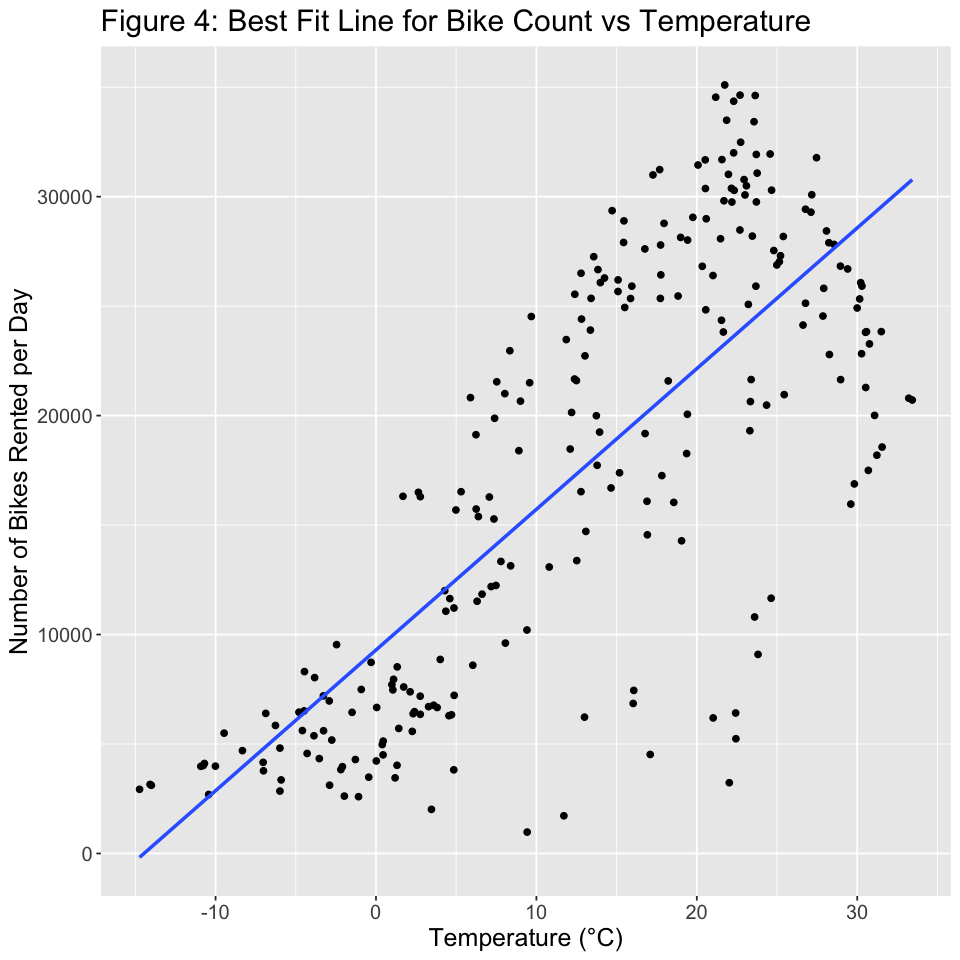

In [10]:
lm_plot_1 <- bike_training |>
    ggplot(aes(x = temperature, y = bike_count)) +
        geom_point() +
        geom_smooth(method = "lm", se = FALSE) +
        labs(x = "Temperature (°C)", y = "Number of Bikes Rented per Day") +
        ggtitle("Figure 4: Best Fit Line for Bike Count vs Temperature") +
        theme(text = element_text(size = 15))
lm_plot_1

In Figure 4, the trendline (best fit line in blue) is increasing which shows a positive relationship between the temperature (°C) and the number of bikes rented per day. The points are scattered and spread out around the trendline which shows a moderately-strong positive relationship between the variables.

Now that we have a model trained with temperature, we will explore a linear regression model with our other predictor, solar radiation. Like before, we create a recipe and load that and the previously made spec into a workflow, find the line of best fit and determine the $RMSPE$ value, as shown below.

In [11]:
bike_recipe_2 <- recipe(bike_count ~ solar_radiation, data = bike_training)

bike_fit_2 <- workflow() |>
    add_recipe(bike_recipe_2) |>
    add_model(lm_spec) |>
    fit(data = bike_training)

lm_rmse_2 <- bike_fit_2 |>
        predict(bike_training) |>
        bind_cols(bike_training) |>
        metrics(truth = bike_count, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()

lm_rmspe_2 <- bike_fit_2 |>
        predict(bike_testing) |>
        bind_cols(bike_testing) |>
        metrics(truth = bike_count, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()

bike_fit_2
lm_rmse_2
lm_rmspe_2

══ Workflow [trained] ═══════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
    (Intercept)  solar_radiation  
           4602            23038  


[1] 6557.239

[1] 7081.062

The $RMSE$ value is 6557.24 and the $RMSPE$ value is 7081.06. The equation for the line of best fit is $y = 4602 + 23038x_1$ where:
- $y$ = Number of bikes rented per day
- $x_1$ = Solar Radiation $(MJ/m^2)$

`geom_smooth()` using formula = 'y ~ x'


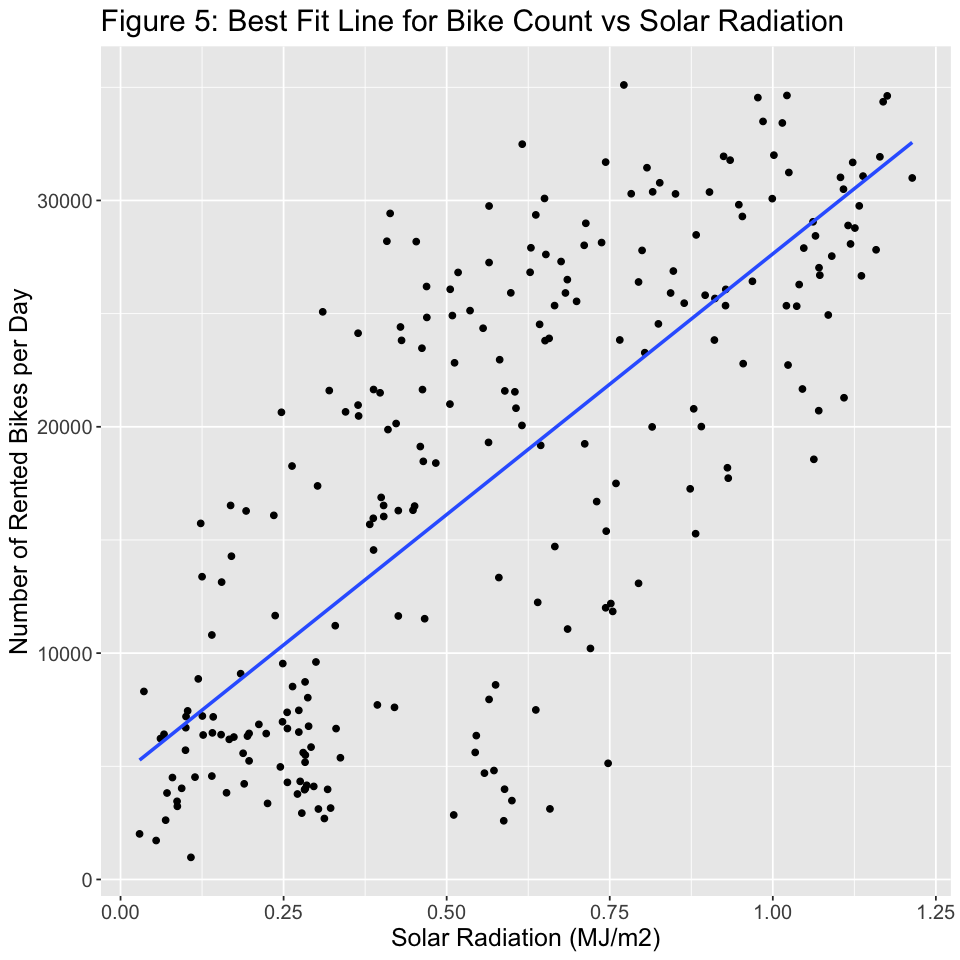

In [12]:
lm_plot_2 <- bike_training |>
    ggplot(aes(x = solar_radiation, y = bike_count)) +
        geom_point() +
        geom_smooth(method = "lm", se = FALSE) +
        labs(x = "Solar Radiation (MJ/m2)", y = "Number of Rented Bikes per Day") +
        ggtitle("Figure 5: Best Fit Line for Bike Count vs Solar Radiation") +
        theme(text = element_text(size = 15))
lm_plot_2 

Figure 5 is a scatter plot of the data which shows that the blue trendline (the best fit line) is increasing, demonstrating a positive relationship between the solar radiation $(MJ/m^2)$ and the number of bikes rented per day. The points are a bit scattered and spread out around the trendline which demonstrates a moderately weak positive relationship between the variables.

The $RMSPE$ value for the model that uses solar radiation as the predictor (7081.06) was higher than that of the model that uses temperature as the predictor (6818.74). This makes the model using temperature as the predictor an overall a better model than that of solely the solar radiation.
With that in mind, we will follow the same procedure to construct a final linear regression model with both environmental factors (temperature and solar radiation), to see how the $RMSPE$ values compare. 

In [13]:
bike_recipe_3 <- recipe(bike_count ~ temperature + solar_radiation, data = bike_training)

bike_fit_3 <- workflow() |>
    add_recipe(bike_recipe_3) |>
    add_model(lm_spec) |>
    fit(data = bike_training)

lm_rmse_3 <- bike_fit_3 |>
        predict(bike_training) |>
        bind_cols(bike_training) |>
        metrics(truth = bike_count, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()

lm_rmspe_3 <- bike_fit_3 |>
        predict(bike_testing) |>
        bind_cols(bike_testing) |>
        metrics(truth = bike_count, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()

bike_fit_3
lm_rmse_3
lm_rmspe_3

══ Workflow [trained] ═══════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
    (Intercept)      temperature  solar_radiation  
         3985.3            422.8          14480.5  


[1] 5074.04

[1] 5766.279

The $RMSE$ value for this model is 5074.04, and the $RMSPE$ value is 5766.28. The equation for the line of best fit is $y = 3985.3 + 422.8x_1 + 14480.5x_2$ where:
- $y$ = Number of bikes rented per day
- $x_1$ = Temperature (°C)
- $x_2$ = Solar Radiation $(MJ/m^2)$

When comparing the 3 different linear regression models, we notice that the $RMSPE$ value for the model with both predictors is lower than the models that use only one predictor. Therefore, the model that uses both predictors is a better model to predict the number of bikes rented per day.

#### K-NN Regression

Moving on to K-NN regression, we will create a spec and recipe for the model, while scaling and centering the predictor values so that each predictor evenly affects the outcome. We will also perform 10-fold cross validation so that we can get a better estimate of accuracy, which will lead to a better choice for the number of neighbors K. Then we will tune our model to determine the best K, ranging from 1 to 100, and will use the K value with the smallest error to fit our model to the training data. Finally, we will test our model with the testing data to see how it performs with data it has not seen before. 

First, we will start with a model that uses only temperature as the predictor.

In [14]:
set.seed(1000)

bike_spec_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression") 

bike_recipe_1 <- recipe(bike_count ~ temperature, data = bike_training) |>
       step_scale(all_predictors()) |>
       step_center(all_predictors())

bike_vfold_1 <- vfold_cv(bike_training, v = 10, strata = bike_count)

bike_workflow_1 <- workflow() |>
  add_recipe(bike_recipe_1) |>
  add_model(bike_spec_1)

gridvals <- tibble(neighbors = seq(from = 1, to = 100))

bike_results_1 <- bike_workflow_1 |>
  tune_grid(resamples = bike_vfold_1, grid = gridvals) |>
  collect_metrics() 

bike_min_1 <- bike_results_1 |>
    filter(.metric == "rmse") |>
    arrange(mean) |> 
    slice(1)
bike_min_1

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
27,rmse,standard,5703.799,10,433.9843,Preprocessor1_Model027


We find that 27 neighbours give us the lowest $RMSE$ value. To test our model, we will assess its $RMSPE$ by creating a model using 27 neighbors and then assess its accuracy on the testing data set. First we pull the best value for neighbors and store it in the object k_min_1.
We then repeat the workflow analysis with a new model trained with the best neighbor value. We then use `predict` function to make predictions using the test data, and use the `metrics` function to create a summary of the model's regression accuracy.

In [15]:
k_min_1 <- bike_min_1 |>
          pull(neighbors)

bike_best_spec_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min_1) |>
          set_engine("kknn") |>
          set_mode("regression")

bike_best_fit_1 <- workflow() |>
          add_recipe(bike_recipe_1) |>
          add_model(bike_best_spec_1) |>
          fit(data = bike_training)

bike_summary_1 <- bike_best_fit_1 |>
           predict(bike_testing) |>
           bind_cols(bike_testing) |>
           metrics(truth = bike_count, estimate = .pred) |>
           filter(.metric == "rmse")       
bike_summary_1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6092.349


The $RMSPE$ value is found to be 6092.35. Below, we create a plot to better visualize the relation between bike count and temperature with our best neighbors value. Before creating the plot, we use the predict function on the workflow analysis that contained the best neighbor value to create predictions for the training data.

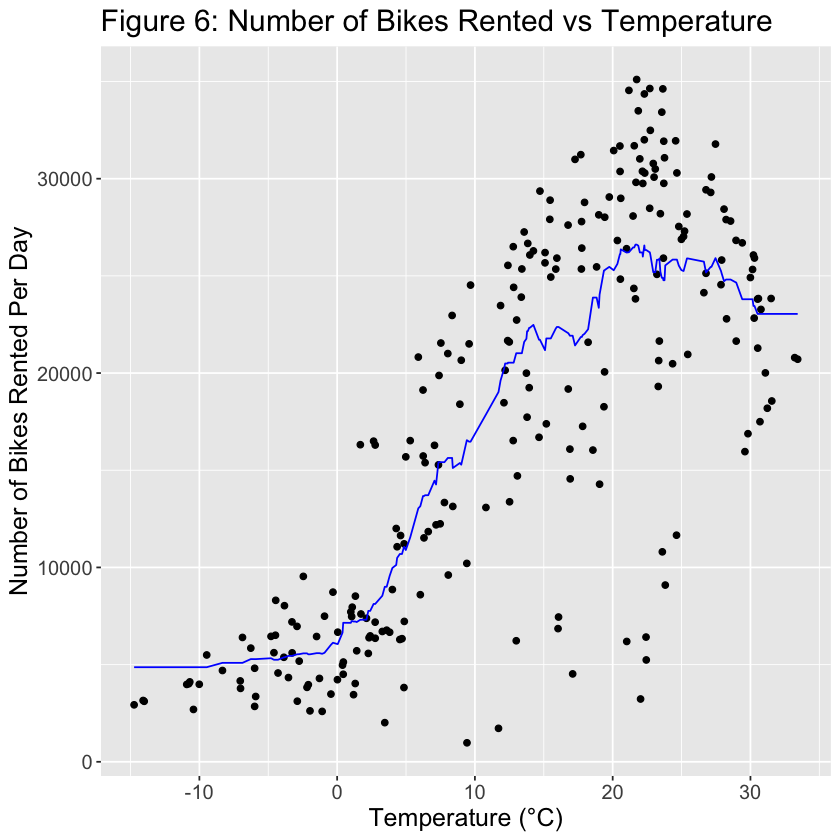

In [16]:
set.seed(1003)

options(repr.plot.width = 7, repr.plot.height = 7)

bike_preds_1 <- bike_best_fit_1 |>
    predict(bike_training) |>
    bind_cols(bike_training)

bike_plot_1 <- ggplot(bike_preds_1, aes(x = temperature, y = bike_count)) +
    geom_point() + labs(x = "Temperature (°C)", y = "Number of Bikes Rented Per Day") +
    geom_line(data = bike_preds_1, 
            mapping = aes(x = temperature, y = .pred), 
            color = "blue") +
    ggtitle("Figure 6: Number of Bikes Rented vs Temperature") +
    theme(text = element_text(size = 15))
bike_plot_1

Figure 6 shows the data with the best fit curve (blue), which estimates the number of bikes rented per day based on temperature. 

Using the same procedure as above, we will now create a K-NN regression model that uses solar radiation as the predictor of rented bike counts. 

In [17]:
set.seed(1004)

bike_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression") 

bike_recipe_2 <- recipe(bike_count ~ solar_radiation, data = bike_training) |>
       step_scale(all_predictors()) |>
       step_center(all_predictors())

bike_vfold_2 <- vfold_cv(bike_training, v = 10, strata = bike_count)

bike_workflow_2 <- workflow() |>
  add_recipe(bike_recipe_2) |>
  add_model(bike_spec_2)

gridvals <- tibble(neighbors = seq(from = 1, to = 100))

bike_results_2 <- bike_workflow_2 |>
  tune_grid(resamples = bike_vfold_2, grid = gridvals) |>
  collect_metrics() 

bike_min_2 <- bike_results_2 |>
    filter(.metric == "rmse") |>
    arrange(mean) |> 
    slice(1)
bike_min_2

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
38,rmse,standard,6383.164,10,275.1155,Preprocessor1_Model038


In [18]:
k_min_2 <- bike_min_2 |>
          pull(neighbors)

bike_best_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min_2) |>
          set_engine("kknn") |>
          set_mode("regression")

bike_best_fit_2 <- workflow() |>
          add_recipe(bike_recipe_2) |>
          add_model(bike_best_spec_2) |>
          fit(data = bike_training)

bike_summary_2 <- bike_best_fit_2 |>
           predict(bike_testing) |>
           bind_cols(bike_testing) |>
           metrics(truth = bike_count, estimate = .pred) |>
           filter(.metric == "rmse")       
bike_summary_2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,7088.661


Using K = 38, the $RMSE$ value is found to be 6383.16 and the $RMSPE$ value is found to be 7088.66, which are both higher than the values we obtained using temperature as the only predictor. This demonstrates that similar to our linear regression analysis, the K-NN regression model that uses temperature as the only predictor is again more accurate than the model that uses solar radiation when estimating the number of bikes rented per day. 

Below, we create a scatter plot to show rented bike count vs solar radiation with our predicted model curve (shown in blue).

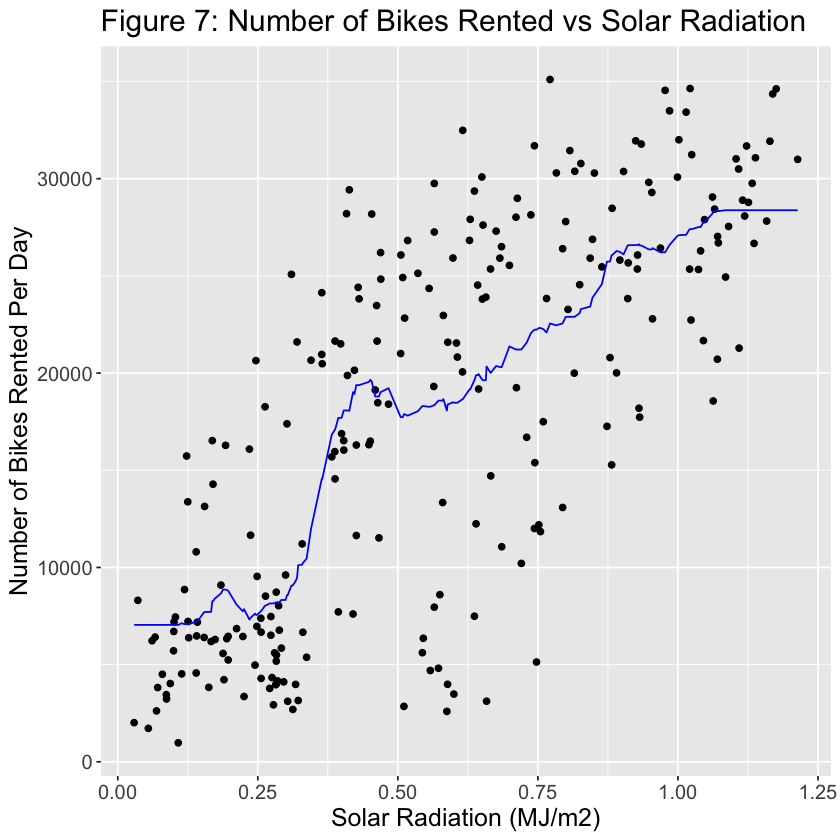

In [19]:
set.seed(1007)

options(repr.plot.width = 7, repr.plot.height = 7)

bike_preds_2 <- bike_best_fit_2 |>
    predict(bike_training) |>
    bind_cols(bike_training)

bike_plot_2 <- ggplot(bike_preds_2, aes(x = solar_radiation, y = bike_count)) +
    geom_point() + labs(x = "Solar Radiation (MJ/m2)", y = "Number of Bikes Rented Per Day") +
    geom_line(data = bike_preds_2, 
            mapping = aes(x = solar_radiation, y = .pred), 
            color = "blue") +
    ggtitle("Figure 7: Number of Bikes Rented vs Solar Radiation") + 
    theme(text = element_text(size = 15))
bike_plot_2

Figure 7 scatterplot shows the data with the prediction curve (blue), which predicts the bike count based on solar radiation. 

Finally, we will create a K-NN model that uses both temperature and solar radiation as predictors.

In [ ]:
set.seed(1008)

bike_spec_3 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression") 

bike_recipe_3 <- recipe(bike_count ~ temperature + solar_radiation, data = bike_training) |>
       step_scale(all_predictors()) |>
       step_center(all_predictors())

bike_vfold_3 <- vfold_cv(bike_training, v = 10, strata = bike_count)

bike_workflow_3 <- workflow() |>
  add_recipe(bike_recipe_3) |>
  add_model(bike_spec_3)

gridvals <- tibble(neighbors = seq(from = 1, to = 100))

bike_results_3 <- bike_workflow_3 |>
  tune_grid(resamples = bike_vfold_3, grid = gridvals) |>
  collect_metrics() 

bike_min_3 <- bike_results_3 |>
    filter(.metric == "rmse") |>
    arrange(mean) |> 
    slice(1)
bike_min_3

In [ ]:
k_min_3 <- bike_min_3 |>
          pull(neighbors)

bike_best_spec_3 <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min_3) |>
          set_engine("kknn") |>
          set_mode("regression")

bike_best_fit_3 <- workflow() |>
          add_recipe(bike_recipe_3) |>
          add_model(bike_best_spec_3) |>
          fit(data = bike_training)

bike_summary_3 <- bike_best_fit_3 |>
           predict(bike_testing) |>
           bind_cols(bike_testing) |>
           metrics(truth = bike_count, estimate = .pred) |>
           filter(.metric == "rmse")       
bike_summary_3

The $RMSE$ value is found to be 3556.36 and the $RMSPE$ value is found to be 3782.12, which are the lowest error values out of the three K-NN models we created.

## Discussion

The question we were trying to answer was: in 2018, in Seoul, Korea, what were the strongest environmental predictors of the quantity of bikes rented out each day, and how effectively can those predictors be used to predict the number of bikes rented out on a given day given the environmental conditions of that day? We narrowed down the data to use the two predictors with the strongest correlation coefficients, temperature and solar radiation, which had correlation coefficients of 0.764 and 0.750, respectively.

Overall, the $RMSPE$ values for both K nearest neighbours regression and linear regression were lowest when we used both solar radiation and temperature as predictors. We also found that the K-NN regression models have lower $RMSPE$ values than that of linear regression, so the models that used K-NN regression were more accurate. We can therefore conclude that the K-NN regression model with two predictors (temperature and solar radiation) with 9 neighbours is the best model, since it is most accurate with the lowest $RMSPE$ (3782). This means that when given the temperature and solar radiation of a given day, the predicted number of bikes rented  will differ from the actual value by an average of 3782 bikes. This shows that the prediction model is fairly accurate because when we look at the range of bike counts (~35,000) as shown in Figure 1, 3782 is not that significant.  

According to a number of articles on biking in South Korea, it was found that cycling is a very common mode of transportation and that Korea is one of the best places to bike. Hall states that "at any time of year, South Korea is an ideal country to explore by bike" (2022). For these reasons, we expected harsh weather conditions such as snowfall and rainfall to not contain very strong correlations and according to the bar graph created, they both had fairly weak correlations below 0.3. However, values like temperature and solar radiation influence bike rentals. Temperature was expected, but not solar radiation. According to Jensen, "... it's cold enough to be dangerous or unpleasant if you're not prepared," (2022). Cold weather is one of the only deterrents in Seoul, Korea, because it can be dangerous to bike without the proper equipment. We can predict that people would opt for other transportation options when the temperature drops.

Our findings demonstrate that people are more likely to ride bikes in warmer temperatures and when there is higher solar radiation. This information is useful to bike sharing companies because they can offer discounts during times when bike rentals are low (such as colder temperatures and non sunny days), in order to increase users and increase profits. Additionally, these findings demonstrate that bike rental businesses tend to do well in Seoul because harsh/extreme changes in precipitation don’t have much of an effect on customer usage. Therefore, this information could be useful for investors or people who would like to open a new bike rental company because Seoul is a place that could potentially be very successful. These findings could also pose questions about reduced carbon footprint for Korea in the future, since weather doesn't deter people from biking. In addition, it could be useful to study the environmental and social impacts of bike sharing in Korea. Our findings lead to further inquiries, including whether there are impacts/rises in life expectancy as people use bikes more and whether people become less stressed due to constant exposure to the positive and healthy effects that come from bike riding in Seoul.

## References

Cricchio, Michaela. “How to Rent Bikes in Seoul: Bike Ride on the Han River or Just Get from a to B.” The Soul of Seoul, 10 Nov. 2020, thesoulofseoul.net/how-to-rent-bike-in-seoul/.

Hall, Jarrod. “Winter Cycling in South Korea - Tips & Gear to Keep Riding in Freezing Temperatures.” Korean Rooftop, www.koreanrooftop.com/blog/winter-cycling-in-korea#:~:text=Winter%20cycling%20in%20Korea%20is. Accessed 5 Dec. 2022.

Jensen, Erik. “Cycling in South Korea: 5 Best Paths, When to Go, and Travel Tips.” Bookmundi.com, 11 May 2021, www.bookmundi.com/t/cycling-in-south-korea-5-best-paths. Accessed 4 Dec. 2022.

Joo-Heon, Kim. “Seoul's Public Bike Rental Service Becomes Popular Public Transport System.” AJU   Business Daily, 27 Apr. 2022, https://www.ajudaily.com/view/20220427094305098. 